In [4]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
from datetime import date
from dateutil.relativedelta import relativedelta
import requests as rq
from tqdm import tqdm
import re

In [6]:
# KOSPI와 KOSDAQ 종목 리스트 불러오기
kospi_list = fdr.StockListing('KOSPI')
kosdaq_list = fdr.StockListing('KOSDAQ')

kospi_list

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,57000,2,-500,-0.87,58000,58300,57000,13877396,799664427482,340277605350000,5969782550,STK
1,000660,KR7000660001,SK하이닉스,KOSPI,,200500,1,3100,1.57,200500,203000,198800,3031573,609386355500,145964474182500,728002365,STK
2,373220,KR7373220003,LG에너지솔루션,KOSPI,,398500,1,12500,3.24,394500,408500,394000,379413,151982513500,93249000000000,234000000,STK
3,207940,KR7207940008,삼성바이오로직스,KOSPI,,1004000,1,9000,0.90,1003000,1014000,998000,65322,65649188000,71458696000000,71174000,STK
4,005380,KR7005380001,현대차,KOSPI,,203500,2,-4000,-1.93,209500,210500,202500,716859,147373827000,42616194868500,209416191,STK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,002995,KR7002991008,금호건설우,KOSPI,,10190,1,1270,14.24,8900,10190,8900,1839,16798860,2978190540,292266,STK
955,014915,KR7014911002,성문전자우,KOSPI,,4890,3,0,0.00,4825,4890,4825,308,1486590,2934000000,600000,STK
956,004415,KR7004411005,서울식품우,KOSPI,,1278,3,0,0.00,1270,1284,1270,8219,10450332,2842911000,2224500,STK
957,001527,KR7001522002,동양2우B,KOSPI,,9140,2,-10,-0.11,9150,9150,9000,177,1600770,2820320660,308569,STK


In [8]:
# KOSPI와 KOSDAQ 종목 리스트 불러오기
kospi_list = fdr.StockListing('KOSPI')
kosdaq_list = fdr.StockListing('KOSDAQ')

# KOSPI와 KOSDAQ 구분을 위한 Market 열 추가
kospi_list['Market'] = 'KOSPI'
kosdaq_list['Market'] = 'KOSDAQ'

# 필요한 열만 선택하여 하나의 데이터프레임으로 병합
stock_list = pd.concat([kospi_list[['Code', 'Name', 'Market']], kosdaq_list[['Code', 'Name', 'Market']]])
stock_list.columns = ['종목코드', '종목명', '시장구분']
stock_list.reset_index(drop=True, inplace=True)

# 데이터 확인
stock_list.head()

,종목코드,종목명,시장구분
0,005930,삼성전자,KOSPI
1,000660,SK하이닉스,KOSPI
2,373220,LG에너지솔루션,KOSPI
3,207940,삼성바이오로직스,KOSPI
4,005380,현대차,KOSPI


In [12]:
# 데이터 다운로드 기간 설정 (최근 5년)
start_date = (date.today() + relativedelta(years=-15)).strftime("%Y-%m-%d")
end_date = date.today().strftime("%Y-%m-%d")

# 주가 데이터를 담을 리스트 초기화
price_data_list = []

# 모든 종목의 주가 데이터를 가져오기
for code in tqdm(stock_list['종목코드']):
    df = fdr.DataReader(code, start_date, end_date)
    if not df.empty:
        df['종목코드'] = code  # 종목코드를 추가해 구분할 수 있도록 합니다
        price_data_list.append(df)

# 주가 데이터를 하나의 데이터프레임으로 병합
price_data = pd.concat(price_data_list)
price_data.reset_index(inplace=True)
price_data.rename(columns={'Date': '날짜'}, inplace=True)
price_data.head()

100%|██████████| 2726/2726 [03:36<00:00, 12.60it/s] 


,날짜,Open,High,Low,Close,Volume,Change,종목코드
0,2009-11-09,14539,14640,14440,14480,269437,0.002770,005930
1,2009-11-10,14680,14720,14479,14540,392417,0.004144,005930
2,2009-11-11,14640,14700,14320,14700,319873,0.011004,005930
3,2009-11-12,14739,14860,14400,14400,494977,-0.020408,005930
4,2009-11-13,14480,14540,14180,14280,431814,-0.008333,005930


In [13]:
price_data.to_csv('price_data.csv', index=False)

In [14]:
# 필요한 열 선택 및 결측치 제거
price_data = price_data[['날짜', '종목코드', 'Close', 'Open', 'High', 'Low', 'Volume']]
price_data.dropna(inplace=True)
price_data.reset_index(drop=True, inplace=True)

# 일별 수익률과 20일 변동성 계산
price_data['일별수익률'] = price_data.groupby('종목코드')['Close'].pct_change()
price_data['변동성(20일)'] = price_data.groupby('종목코드')['Close'].rolling(window=20).std().reset_index(level=0, drop=True)

# 종목 정보와 주가 데이터를 병합하여 KOSPI, KOSDAQ 구분 추가
final_data = pd.merge(price_data, stock_list, on='종목코드', how='left')
final_data.head()

,날짜,종목코드,Close,Open,High,Low,Volume,일별수익률,변동성(20일),종목명,시장구분
0,2009-11-09,005930,14480,14539,14640,14440,269437,NaN,NaN,삼성전자,KOSPI
1,2009-11-10,005930,14540,14680,14720,14479,392417,0.004144,NaN,삼성전자,KOSPI
2,2009-11-11,005930,14700,14640,14700,14320,319873,0.011004,NaN,삼성전자,KOSPI
3,2009-11-12,005930,14400,14739,14860,14400,494977,-0.020408,NaN,삼성전자,KOSPI
4,2009-11-13,005930,14280,14480,14540,14180,431814,-0.008333,NaN,삼성전자,KOSPI


In [15]:
final_data.to_pickle('final_data.pkl')

In [16]:
stock_list.to_csv('stock_list.csv', index=False)

In [20]:
# 종목코드 005930에 해당하는 데이터만 추출
final_data[final_data['종목코드'] == '005930'].to_csv('005930.csv', index=False)

In [17]:
stock_list

,종목코드,종목명,시장구분
0,005930,삼성전자,KOSPI
1,000660,SK하이닉스,KOSPI
2,373220,LG에너지솔루션,KOSPI
3,207940,삼성바이오로직스,KOSPI
4,005380,현대차,KOSPI
...,...,...,...
2721,475240,하나32호스팩,KOSDAQ
2722,438580,엔에이치스팩25호,KOSDAQ
2723,023460,CNH,KOSDAQ
2724,021045,대호특수강우,KOSDAQ


In [30]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# 데이터 로드
data = pd.read_csv("005930.csv", parse_dates=['날짜'])  # date 열을 datetime 형식으로 파싱
data = data.dropna()  # 결측치 제거
data.head()

,날짜,종목코드,Close,Open,High,Low,Volume,일별수익률,변동성(20일),종목명,시장구분
19,2009-12-04,5930,15240,15160,15340,15099,366960,0.003953,321.697799,삼성전자,KOSPI
20,2009-12-07,5930,15420,15400,15540,15260,329583,0.011811,344.209239,삼성전자,KOSPI
21,2009-12-08,5930,15440,15419,15520,15340,201922,0.001297,363.681468,삼성전자,KOSPI
22,2009-12-09,5930,15560,15240,15639,15220,356783,0.007772,392.589246,삼성전자,KOSPI
23,2009-12-10,5930,15760,15420,15759,15320,891683,0.012853,416.648280,삼성전자,KOSPI


In [38]:
# 칼럼명 수정
data['daily_return'] = data['Close'].pct_change()
data['volatility'] = data['Close'].rolling(window=20).std()  # 20일 이동표준편차

# RSI 계산 (상대강도지수, 14일 기준)
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

# MACD 계산
ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema_12 - ema_26
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

# 볼린저 밴드 계산
data['MA20'] = data['Close'].rolling(window=20).mean()
data['BB_upper'] = data['MA20'] + (2 * data['Close'].rolling(window=20).std())
data['BB_lower'] = data['MA20'] - (2 * data['Close'].rolling(window=20).std())

# 1일 후 종가가 상승하면 1, 하락하면 0으로 라벨링
data['target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
data = data.dropna()  # 이후 생긴 결측치 제거

# 사용하지 않을 열 제거 (str 데이터 포함)
X = data.drop(columns=['날짜', 'Open', 'High', 'Low', 'Close', 'Volume', 'target', '종목코드', '종목명', '시장구분'])
y = data['target']

# 시계열 고려한 학습-테스트 분할
tscv = TimeSeriesSplit(n_splits=5)
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)

# 시계열 교차 검증
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    gb_clf.fit(X_train, y_train)
    y_pred = gb_clf.predict(X_test)
    print(f"정확도: {accuracy_score(y_test, y_pred):.4f}")


정확도: 0.5446
정확도: 0.5149
정확도: 0.4257
정확도: 0.5347
정확도: 0.4851


C:\Users\FELAB\AppData\Local\Temp\ipykernel_28908\4152515910.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['strategy_return'] = data['daily_return'] * data['prediction']  # 상승 예측 시에만 일일 수익률 반영
C:\Users\FELAB\AppData\Local\Temp\ipykernel_28908\4152515910.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cumulative_strategy_return'] = (1 + data['strategy_return']).cumprod() - 1  # 전략의 누적 수익률
C:\Users\FELAB\AppData\Local\Temp\ipykernel_28908\4152515910.py:10: SettingWithCopyWarning: 
A value

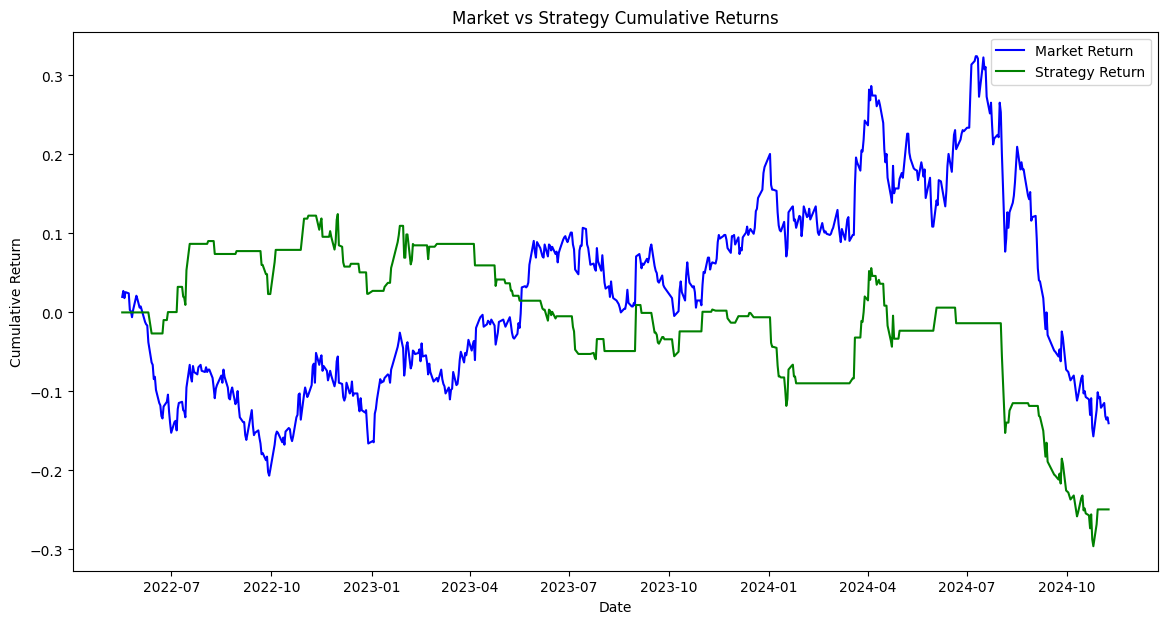

최종 전략 수익률: -24.93%
최종 시장 수익률: -14.03%


In [39]:
import matplotlib.pyplot as plt

# 예측 결과를 기존 데이터에 추가
data.loc[y_test.index, 'prediction'] = y_pred

# 투자 전략 수익률 계산
# (예측 상승일 경우 주식을 매수, 하락일 경우 현금을 유지한다고 가정)
data['strategy_return'] = data['daily_return'] * data['prediction']  # 상승 예측 시에만 일일 수익률 반영
data['cumulative_strategy_return'] = (1 + data['strategy_return']).cumprod() - 1  # 전략의 누적 수익률
data['cumulative_market_return'] = (1 + data['daily_return']).cumprod() - 1  # 시장의 누적 수익률

# 누적 수익률 비교 시각화
plt.figure(figsize=(14, 7))
plt.plot(data['날짜'], data['cumulative_market_return'], label='Market Return', color='blue')
plt.plot(data['날짜'], data['cumulative_strategy_return'], label='Strategy Return', color='green')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Market vs Strategy Cumulative Returns')
plt.legend()
plt.show()

# 백테스트 결과 평가
final_strategy_return = data['cumulative_strategy_return'].iloc[-1]
final_market_return = data['cumulative_market_return'].iloc[-1]
print(f"최종 전략 수익률: {final_strategy_return:.2%}")
print(f"최종 시장 수익률: {final_market_return:.2%}")


In [34]:
data

,날짜,종목코드,Close,Open,High,Low,Volume,일별수익률,변동성(20일),종목명,...,MACD,Signal_Line,MA20,BB_upper,BB_lower,target,prediction,strategy_return,cumulative_strategy_return,cumulative_market_return
38,2010-01-05,5930,16440,16520,16580,16300,559219,0.016069,287.308746,삼성전자,...,204.552942,127.797249,15659.0,16233.617493,15084.382507,1,NaN,NaN,NaN,0.016069
39,2010-01-06,5930,16820,16580,16820,16520,459755,0.023114,371.052557,삼성전자,...,266.740594,155.585918,15738.0,16480.105114,14995.894886,0,NaN,NaN,NaN,0.039555
40,2010-01-07,5930,16260,16820,16820,16260,443237,-0.033294,380.581273,삼성전자,...,267.750970,178.018928,15780.0,16541.162546,15018.837454,1,NaN,NaN,NaN,0.004944
41,2010-01-08,5930,16420,16400,16420,16120,295798,0.009840,397.225907,삼성전자,...,278.254815,198.066106,15829.0,16623.451814,15034.548186,0,NaN,NaN,NaN,0.014833
42,2010-01-11,5930,15940,16420,16460,15940,398901,-0.029233,392.744728,삼성전자,...,245.022729,207.457430,15848.0,16633.489455,15062.510545,1,NaN,NaN,NaN,-0.014833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3694,2024-11-04,5930,58700,58600,59400,58400,15586947,0.006861,1310.484041,삼성전자,...,-1753.750621,-2240.997083,59050.0,61670.968081,56429.031919,0,1.0,0.006861,-0.158988,2.627936
3695,2024-11-05,5930,57600,57800,58100,57200,17484474,-0.018739,1263.912056,삼성전자,...,-1720.942770,-2136.986221,58880.0,61407.824111,56352.175889,0,1.0,-0.018739,-0.174748,2.559951
3696,2024-11-06,5930,57300,57600,58000,56300,22092218,-0.005208,1264.536528,삼성전자,...,-1699.558354,-2049.500647,58730.0,61259.073057,56200.926943,1,1.0,-0.005208,-0.179046,2.541409
3697,2024-11-07,5930,57500,56900,58100,56800,17043102,0.003490,1293.058390,삼성전자,...,-1647.481580,-1969.096834,58660.0,61246.116780,56073.883220,0,1.0,0.003490,-0.176181,2.553770


In [18]:
import pandas as pd
import requests as rq
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
import time

# 재무제표 클렌징 함수
def clean_fs(df, ticker, frequency):
    df = df[~df.loc[:, ~df.columns.isin(['계정'])].isna().all(axis=1)]
    df = df.drop_duplicates(['계정'], keep='first')
    df = pd.melt(df, id_vars='계정', var_name='기준일', value_name='값')
    df = df[~pd.isnull(df['값'])]
    df['계정'] = df['계정'].replace({'계산에 참여한 계정 펼치기': ''}, regex=True)
    df['기준일'] = pd.to_datetime(df['기준일'], format='%Y-%m') + pd.tseries.offsets.MonthEnd()
    df['종목코드'] = ticker
    df['공시구분'] = frequency
    return df

# 티커 리스트를 준비 (예시로 삼성전자 등 일부 티커만 포함)
ticker_list = stock_list

# 결과 저장 리스트
financial_data = []

# for loop
for i in tqdm(range(len(ticker_list))):
    ticker = ticker_list['종목코드'][i]

    try:
        # URL 생성
        url = f'http://comp.fnguide.com/SVO2/ASP/SVD_Finance.asp?pGB=1&gicode=A{ticker}'
        data = pd.read_html(url, displayed_only=False)

        # 연간 데이터 처리
        data_fs_y = pd.concat([data[0].iloc[:, ~data[0].columns.str.contains('전년동기')], data[2], data[4]])
        data_fs_y = data_fs_y.rename(columns={data_fs_y.columns[0]: "계정"})

        # 결산월 찾기
        page_data = rq.get(url)
        page_data_html = BeautifulSoup(page_data.content, 'html.parser')
        fiscal_data = page_data_html.select('div.corp_group1 > h2')
        fiscal_data_text = re.findall('[0-9]+', fiscal_data[1].text)

        # 결산월에 해당하는 열만 남기기
        data_fs_y = data_fs_y.loc[:, (data_fs_y.columns == '계정') | (data_fs_y.columns.str[-2:].isin(fiscal_data_text))]

        # 클렌징 처리
        data_fs_y_clean = clean_fs(data_fs_y, ticker, 'y')

        # 분기 데이터 처리
        data_fs_q = pd.concat([data[1].iloc[:, ~data[1].columns.str.contains('전년동기')], data[3], data[5]])
        data_fs_q = data_fs_q.rename(columns={data_fs_q.columns[0]: "계정"})
        data_fs_q_clean = clean_fs(data_fs_q, ticker, 'q')

        # 연간 및 분기 데이터 결합
        data_fs_bind = pd.concat([data_fs_y_clean, data_fs_q_clean])
        
        # 최종 데이터를 리스트에 추가
        financial_data.append(data_fs_bind)
        
        # 타임슬립 적용
        time.sleep(2)

    except Exception as e:
        print(f"Error for {ticker}: {e}")

# 리스트를 하나의 DataFrame으로 결합
financial_data_df = pd.concat(financial_data, ignore_index=True)

# 결과 확인
print(financial_data_df.head())


  0%|          | 1/2726 [00:21<15:55:13, 21.03s/it]

Error for 005930: <urlopen error [WinError 10060] 연결된 구성원으로부터 응답이 없어 연결하지 못했거나, 호스트로부터 응답이 없어 연결이 끊어졌습니다>


  0%|          | 2/2726 [00:42<15:55:06, 21.04s/it]

Error for 000660: <urlopen error [WinError 10060] 연결된 구성원으로부터 응답이 없어 연결하지 못했거나, 호스트로부터 응답이 없어 연결이 끊어졌습니다>


  0%|          | 2/2726 [01:03<23:52:39, 31.56s/it]


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np

# 기본 데이터 로드 (예시)
# 데이터가 `kospi_data`, `kosdaq_data`, `financial_data`에 각각 포함되어 있다고 가정
# kospi_data, kosdaq_data는 기본 정보, financial_data는 재무제표 정보

# 예시로 상위 데이터 (KOSPI, KOSDAQ)를 결합
stock_data = pd.concat([kospi_data, kosdaq_data])
stock_data = stock_data.reset_index(drop=True)

# 재무 데이터는 financial_data에 있는 것으로 가정하고 필요 열 선택
# financial_data는 종목코드, 연도별 시가총액, 거래대금, 당기순이익, 배당금, 자사주소각, PBR, ROE 등이 포함되어야 합니다.

# 결합을 위해 stock_data의 '종목코드'와 financial_data의 '종목코드'를 키로 병합
merged_data = pd.merge(stock_data, financial_data, on="종목코드", how="inner")

# 필요한 열이 존재하는지 확인
required_columns = ["종목코드", "종목명", "일평균시가총액", "일평균거래대금", "당기순이익", "배당금", "자사주소각", "PBR", "ROE"]
assert all(col in merged_data.columns for col in required_columns), "데이터에 필요한 열이 없습니다."

### 1단계: 시장 대표성 및 유동성 기준 ###
# 시장 대표성: 일평균 시가총액이 상위 400위 이내 (440위 이내이면 제외 안함)
merged_data = merged_data.sort_values(by="일평균시가총액", ascending=False)
market_representative = merged_data.head(440).copy()  # 기존 종목을 고려하여 440위까지

# 유동성: 일평균 거래대금이 심사대상 종목의 80% 이내
target_count = int(len(merged_data) * 0.8)
market_representative = market_representative.sort_values(by="일평균거래대금", ascending=False).head(target_count)

### 2단계: 수익성 및 주주환원 기준 ###
# 수익성: 최근 2년간 흑자 종목 (당기순이익이 0 이상인 종목)
market_representative = market_representative[
    (market_representative["당기순이익_연도1"] > 0) & (market_representative["당기순이익_연도2"] > 0)
]

# 주주환원: 최근 2년 연속 배당 또는 자사주소각 종목
market_representative = market_representative[
    (market_representative["배당금_연도1"] > 0) | (market_representative["자사주소각_연도1"] > 0) |
    (market_representative["배당금_연도2"] > 0) | (market_representative["자사주소각_연도2"] > 0)
]

### 3단계: 시장평가 기준 (PBR) ###
# PBR 순위 50% 이내 (또는 산업군 내 50% 이내)
market_representative = market_representative.sort_values(by="PBR")
mid_point = len(market_representative) // 2
market_representative = market_representative.head(mid_point)  # PBR 상위 50% 이내

### 4단계: 자본효율성 기준 (ROE) ###
# 최근 2개 사업연도 평균 ROE 값으로 상위 100종목 선정
market_representative = market_representative.sort_values(by="ROE", ascending=False).head(100)

### 5단계: 기업 밸류업 우수법인 (추가 조건) ###
# '기업 밸류업 우수법인' 중 최소 편입 요건을 충족하는 종목을 최종 선정에 포함
# 예시로 우수법인 데이터를 우수법인 리스트로 추가
valuable_firms = ["종목코드1", "종목코드2"]  # 예시
valuable_firm_data = merged_data[merged_data["종목코드"].isin(valuable_firms)]
final_selection = pd.concat([market_representative, valuable_firm_data]).drop_duplicates()

print("최종 선정 종목")
print(final_selection[["종목코드", "종목명", "일평균시가총액", "PBR", "ROE"]])


In [ ]:
# 라이브러리 추가
import requests
import pandas as pd
import io
import time

# 재무제표 크롤링 함수
def crawling_finance(firm_code):
    url = 'https://comp.fnguide.com/SVO2/ASP/SVD_Finance.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=103&stkGb=701&gicode=' + firm_code
    page = requests.get(url)
    table = pd.read_html(io.StringIO(page.text))
    table1 = table[0]
    table1 = table1.set_index(table1.columns[0])
    table1 = table1[table1.columns[:4]]
    table1 = table1.loc[['매출액', '매출총이익', '영업이익', '당기순이익']]
    table2 = table[2]
    table2 = table2.set_index(table2.columns[0])
    table2 = table2.loc[['자산', '부채', '자본']]
    table2.index = ['자산', '부채', '자본']
    table3 = table[4]
    table3 = table3.set_index(table3.columns[0])
    table3 = table3.loc[['영업활동으로인한현금흐름']]
    total_table = pd.concat([table1, table2, table3])
    return total_table

# 저장된 종목코드 불러오기
code_data = pd.read_excel('KRX_stock_list.xlsx')
code_data = code_data[['Code']]

# 재무제표 크롤링
for idx, firm_code in enumerate(code_data['Code']):
    print(idx + 1, '/', len(code_data['Code']))
    try:
        # 종목별 재무제표 크롤링
        try:
            sub_finance_table = crawling_finance(firm_code)
        except requests.exceptions.Timeout:
            time.sleep(60)
            sub_finance_table = crawling_finance(firm_code)

        # 종목별 재무제표 정리
        for num, col in enumerate(sub_finance_table.columns):
            temp = pd.DataFrame({firm_code : sub_finance_table[col]}).T
            temp.columns = [[col] * len(sub_finance_table), temp.columns]
            if num == 0:
                temp_arranged = temp
            else:
                temp_arranged = pd.merge(temp_arranged, temp, how='outer', left_index=True, right_index=True)

        # 재무제표 통합        
        if idx == 0:
            finance_table = temp_arranged
        else:
            finance_table = pd.concat([finance_table, temp_arranged])
    except ValueError:
        continue
    except KeyError:
        continue

# 재무제표 저장
finance_table.to_excel('finance_table.xlsx')